# RNN
> 循环神经网络（RNN）通过引入状态变量来存储过去的信息和当前的输入，从而确定当前的输出。这种结构使得RNN非常适合处理序列信息，因为它可以捕捉到序列中的时间依赖性。这与卷积神经网络（CNN）的工作方式形成了对比，CNN主要用于处理空间信息，如图像等。

### 序列模型
RNN最典型的就是序列预测，简单来说就是以前奥数的找规律，已知$x_1,x_2....x_t$，让你填空$x_{t+1}$是什么，本质上就是推测$x_{t+1}$的概率分布，我们就会拿概率最大的那个作为答案。

- 自回归模型

自回归的意思就是根据过去的一定数量的观测值（比如n个）进行预测，在奥数中我们会找到类似的规律，比如第t个数$x_t$就是
$$
x_{t-3}+x_{t-2}+x_{t-1}
$$

- 马尔可夫模型/性质

当前的状态只和过去的n个参数有关，就是n阶马尔可夫，比如上述情况当前数值是过去三个数相加，那就是3阶马尔可夫。

- 隐变量自回归函数

这种模型除了考虑过去的观测值，还保留了一个对过去观测的总结（隐状态）。这个隐状态是**过去所有的观测记录的一种综合融合特征**，当前的观测值是基于隐状态的条件概率，隐状态则是基于过去的隐状态和过去的观测值（有时候表述为当前观测值，因为**t时刻的输入也可以视为t+1时刻的输出，所以下标和时刻必然存在偏移**）的函数。这也是RNN的核心思想，计算t时刻的输出，需要t时刻的输入$x_t$和过去t-1个时刻所凝练的隐状态$h_{t-1}$。最需要注意的是，**$x_t$和$h_{t-1}$是用于计算新的隐状态$h_t$，t时候预测的输出是再单纯基于$h_t$计算的**

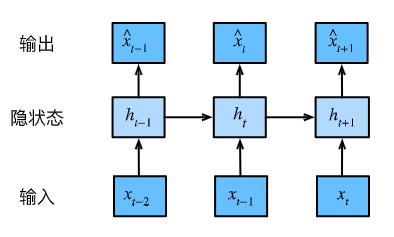


### 语言模型概念
**文本预处理的一般步骤**

1. 加载文本：

将文本数据从文件、数据库或网络资源中读取到内存。清理数据，移除无关的元素，如HTML标签、特殊字符等。

2. 文本分词

将连续的文本字符串拆分成更小的单元，通常是单词、短语或字符。这个过程称为分词。分词可以根据空格、标点符号等来进行，也可以使用更复杂的方法，如使用NLP库的分词器。

3. 构建词表：

创建一个词表，列出文本中出现的所有独特词元，并为它们分配一个唯一的数字索引。有时会添加特殊词元，如<pad>用于序列填充，<unk>用于未知词元，<sos>和<eos>分别表示序列的开始和结束。

4. 文本编码：

将分词后的文本转换为数字索引序列，以便模型可以处理。这通常涉及到one-hot编码或词嵌入（embedding）的使用。One-hot编码为每个词元创建一个很长的向量，其中只有一个位置是1，其余都是0。词嵌入则是将词元映射到一个固定大小的、更稠密的向量，通常是通过预训练的词嵌入模型（如Word2Vec）获得。

##### 示例
原始句子：

"今天天气真好，我们一起去公园玩吧！"

→ "今天天气真好，我们一起去公园玩吧" #去除标点符号

→ ["今天", "天气", "真好", "，", "我们", "一起", "去", "公园", "玩", "吧"] #中文分词工具如jieba分词

```
vocab = {
    "<pad>": 0,   # 填充符
    "<unk>": 1,   # 未知词
    "今天": 2,
    "天气": 3,
    "真好": 4,
    "，": 5,
    "我们": 6,
    "一起": 7,
    "去": 8,
    "公园": 9,
    "玩": 10,
    "吧": 11
}  # 统计所有独特词元并分配索引（假设了一个词表）
```

→ [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] #将分词结果转换为数字序列

> 当下大模型的词表一般都存储大概20000+个词

### RNN概念
RNN简单来说就是用如下公式表示
$$
H_t = \phi(X_tW_{xh} + H_{t-1}W_{hh} + b_{h})
$$

$$
O_t = H_tW_{hq} + b_q
$$

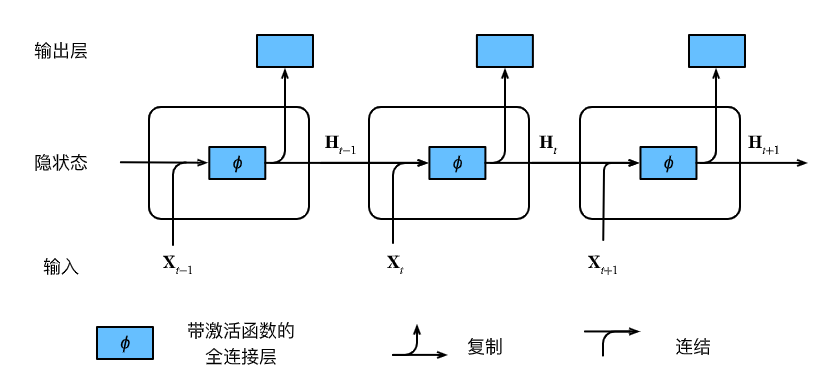

##### 困惑度
困惑度是一个概率模型对给定测试数据集的预测能力的度量，直观上可以理解为模型在预测一个序列时的平均分支数或选择数。一个好的语言模型能够较准确地预测接下来可能出现的单词，因此具有较低的困惑度; **这个概念了解即可，当下没有太多实际意义**

##### 梯度裁剪
对于长度为T的序列，我们在迭代中计算这T个时间步上的梯度，将会在反向传播过程中产生长度为O(T)的矩阵乘法链。梯度剪裁通过限制梯度的大小来解决梯度爆炸问题，确保梯度在一个合理的范围内，从而避免梯度过大导致的问题。这里的g表示梯度向量，(||g||)是梯度向量的范数（例如L2范数），而$\theta$是预先设定的阈值。如果梯度的范数超过了阈值，这个公式将梯度向量缩放到阈值大小。

$$
g \leftarrow min(1,\frac{\theta}{||g||})g
$$

### 经典RNN结构

In [1]:
import torch
import torch.nn as nn

# 定义超参数
input_size = 10   # 输入特征的维度
hidden_size = 20  # 隐藏层的维度
sequence_length = 5  # 序列长度（时间步数）
batch_size = 3     # 批大小

# 生成随机输入数据 (shape: [batch_size, sequence_length, input_size])
random_input = torch.randn(batch_size, sequence_length, input_size)
print("输入数据形状:", random_input.shape)

# 定义一个最简单的RNN模型
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True  # 输入形状为 [batch, seq_len, input_size]
        )
    
    def forward(self, x):
        # RNN前向传播
        # output: 所有时间步的隐藏状态 [batch, seq_len, hidden_size]
        # hidden: 最后一个时间步的隐藏状态 [1, batch, hidden_size]
        output, hidden = self.rnn(x)
        return output, hidden

# 初始化模型
model = SimpleRNN(input_size, hidden_size)

# 前向传播
output, hidden = model(random_input)

print("\n输出结果形状:")
print("所有时间步的输出:", output.shape)  # [batch_size, sequence_length, hidden_size]
print("最后一个时间步的隐藏状态:", hidden.shape)  # [1, batch_size, hidden_size]

输入数据形状: torch.Size([3, 5, 10])

输出结果形状:
所有时间步的输出: torch.Size([3, 5, 20])
最后一个时间步的隐藏状态: torch.Size([1, 3, 20])


##### 输出计算
每一个样本每一个时间步拿到的输出尺寸有hidden_size维，经过一层**全连接层**后变为output_size维，此时需要先注意将其变为一维向量（从1 * 1 * output_size变为 (output_size,)），，需要注意**output_size的大小需要和词汇表的大小一致**，然后经过**softmax**转化为对应词元的概率，再通过**交叉熵损失**与实际标签比较计算损失

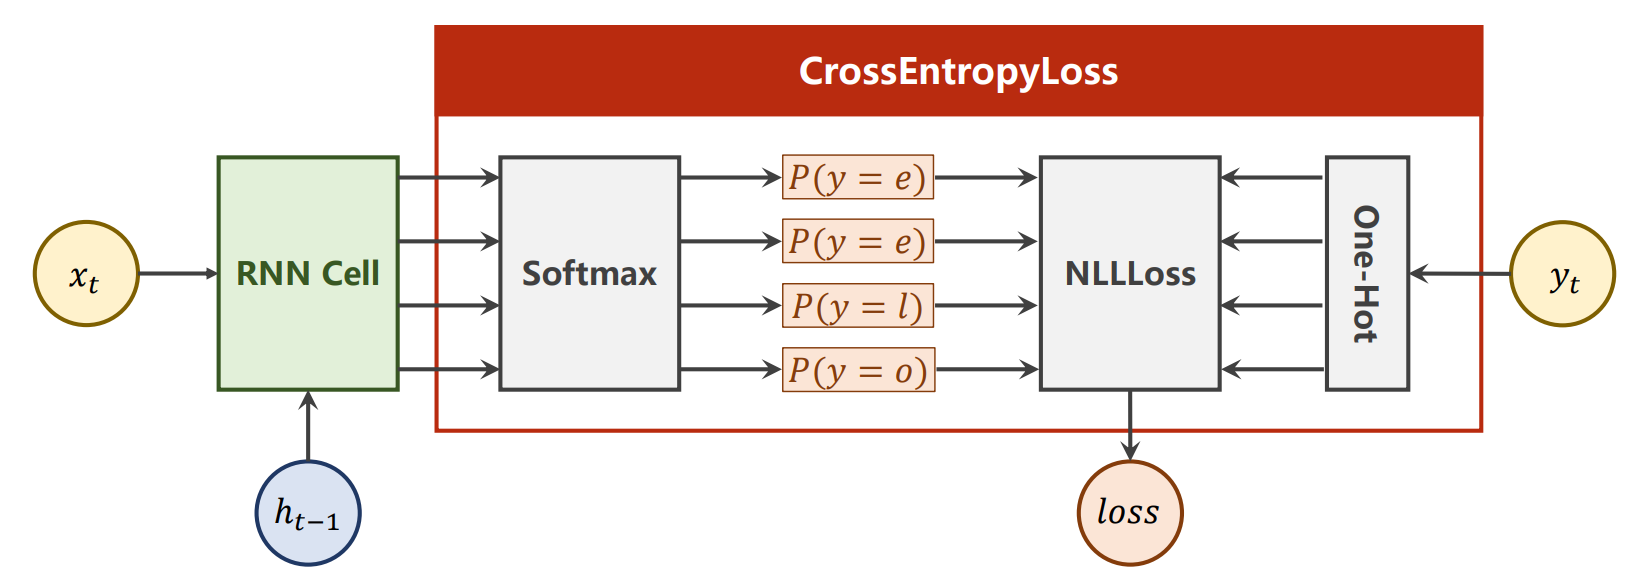

### GRU和LSTM结构
GRU和LSTM结构是两类非常著名的RNN变体，其融入了遗忘门、输入门、输出门等XX门的设计，他们的结构和公式如下
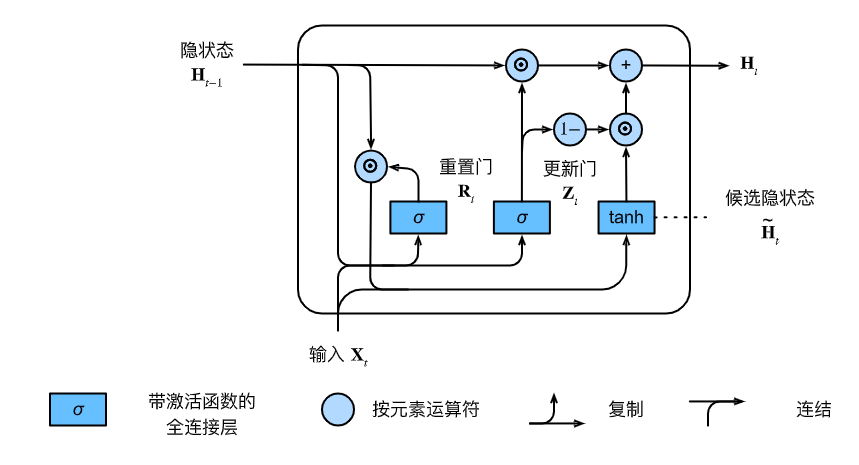
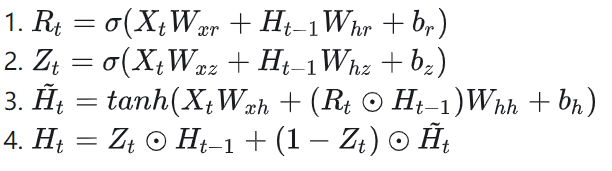
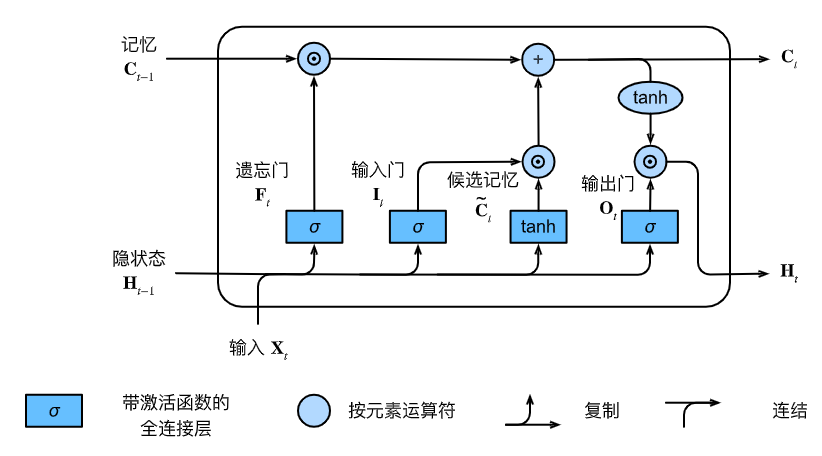
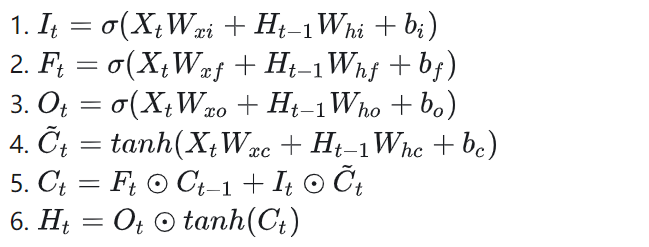

- 两者的原理/解释有点抽象，但是也算是可以接受，不需要细讲，有需要去看即可
- 如果仅仅考虑实现层面，把`nn.RNN`替换为`nn.GRU`或`nn.LSTM`即可

### encoder-decoder架构
编码器-解码器是一种经典的神经网络结构，广泛应用于 序列到序列（Seq2Seq）任务，如机器翻译、文本摘要、语音识别等。它的核心思想是：
1. 编码器（Encoder）：将输入序列（如一句英文）编码成一个固定长度的 上下文向量（Context Vector），捕捉其语义信息。
2. 解码器（Decoder）：基于上下文向量逐步生成输出序列（如对应的中文翻译）。

**典型结构示例**

In [ ]:
import torch
import torch.nn as nn

class EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(EncoderDecoder, self).__init__()
        # 编码器（可以是RNN/GRU/LSTM）
        self.encoder = nn.GRU(input_size, hidden_size, batch_first=True)
        # 解码器（通常与编码器结构对称）
        self.decoder = nn.GRU(output_size, hidden_size, batch_first=True)
        # 全连接层，将隐藏状态映射到输出空间
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, src, tgt):
        # 编码阶段
        _, hidden = self.encoder(src)  # hidden是最后一个时间步的状态
        # 解码阶段（逐步生成）
        outputs, _ = self.decoder(tgt, hidden)
        predictions = self.fc(outputs)
        return predictions

# 示例参数
input_size = 10   # 输入维度（如词嵌入维度）
hidden_size = 32  # 隐藏层维度
output_size = 20  # 输出维度（如目标词汇表大小）
model = EncoderDecoder(input_size, hidden_size, output_size)

# 随机输入（模拟批大小为2，序列长度为5）
src = torch.randn(2, 5, input_size)  # 源语言序列（编码器输入）
tgt = torch.randn(2, 5, output_size) # 目标语言序列（解码器输入）
output = model(src, tgt)
print(output.shape)  # 输出形状: [2, 5, 20]

##### 设计优势
1. 处理变长序列

- 输入和输出序列的长度可以不同（如翻译时英文和中文句子长度不一致，**原始架构有多少时间步的输入就要有多少时间步的输出**）。

- 编码器将变长输入压缩为固定长度的上下文向量，解码器动态展开生成变长输出。

2. 信息压缩与抽象

- 编码器提取输入的高层语义特征（如句子的主旨），解码器基于这些特征生成目标序列，避免逐词硬匹配。

3. 灵活性

- 编码器和解码器可以独立设计（如用CNN编码图像，用RNN解码文本，用于图像描述生成）。

- 支持多种序列任务（如文本生成、语音合成、时间序列预测）。


### Seq2Seq

Seq2Seq就是编码器-解码器架构的一种，专注于序列任务，典型案例如下

In [ ]:
class Seq2SeqEncoder(nn.Module):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # GRU层
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size, num_steps, embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认初始化为0
        output, state = self.rnn(X)
        # output的形状：(num_steps, batch_size, num_hiddens)
        # state的形状：(num_layers, batch_size, num_hiddens)
        return output, state

编码器比较简单，其中
- vocab_size,embed_size分别是词汇表，或者说总词汇数，每个词汇（的索引）对应一个编码向量（以替代one-hot编码），减少长度开销
- output和state是RNN的输出，编码器最后有用的输出（传到解码器的）就一个——最后一个时间步最后一层（如果RNN是多层）的隐状态（batch_size * hidden_size）

In [ ]:
class Seq2SeqDecoder(nn.Module):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)  # 简化的super调用
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size, num_steps, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状：(batch_size, num_steps, vocab_size)
        # state的形状：(num_layers, batch_size, num_hiddens)
        return output, state

解码器难理解一点，重点关注
- 解码器的RNN的输入层输入是embed_size + num_hiddens，num_hiddens是来自编码器隐状态的隐藏层长度；这么做的意图是使得解码器能够接收编码器的输出上下文信息；并且该上下文在解码器的**每个时间步都要加上**，而且**这个向量是不变的**，这个设计是**非必须的，有其他方案**
- `context = state[-1].repeat(X.shape[0], 1, 1)`将这个上下文在num_steps维度进行复制使其和输入X一致，然后拼接
- RNN和全连接层的输入维度排序总是不一样，所以需要`permute`进行调整

### 损失、训练、预测与评估（以翻译为例）

##### 损失
翻译任务的损失还是那一套，输出+全连接+softmax+交叉熵损失，问题在于翻译的输出长度不确定（正确答案10个单词翻译出了15个），这种很难评价。解决方案是**所有预测词元的掩码都被设置为1。一旦给定了有效长度，与填充词元对应的掩码将被设置为0。最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。**
> 但是具体的损失函数实现是有一定理解难度的，因为这块以后基本用不到了，所以不做扩展

##### 训练
采用强制教学方法（teacher forcing）。在这种方法中，序列开始词元（\<bos>）在初始时间步被输入到解码器中，我们使用真实的目标文本作为输入，即将标准答案作为解码器的输入。在每个时间步，解码器会根据当前正确的输出词和上一步的隐状态来预测下一个输出词。这样做的好处是，在训练过程中，模型可以更容易地学习到正确的输出序列，减轻“一步错，步步错”的误差爆炸问题，加快模型的收敛速度。
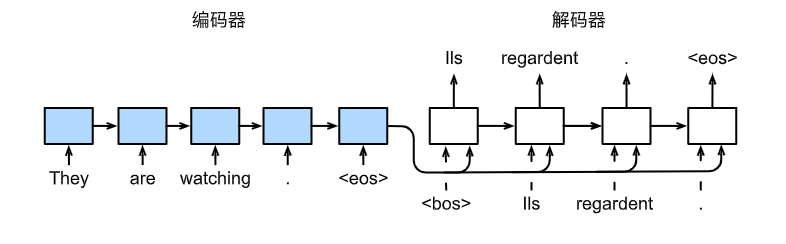

##### 预测
每个解码器当前时间步的输入都是来自前一个时间步的预测词元。与训练过程类似，序列开始词元（\<bos>）在初始时间步被输入到解码器中。预测过程会一直进行，直到输出序列的预测遇到序列结束词元（\<eos>），此时预测过程结束
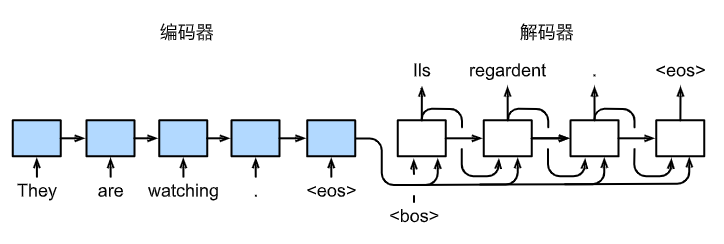

- 贪心搜索：贪心搜索是一种简单直接的策略。在每一步生成序列的过程中，模型会计算下一个最可能的词元（token，可以是词或字符等）的概率，并选择概率最高的那个词元作为当前步骤的输出。

- 穷举搜索是一种理论上的搜索方法。它会计算所有可能输出序列的条件概率，并选择概率最高的序列作为最终输出。由于需要计算所有可能的序列，其计算量非常巨大

- 搜索是贪心搜索的一个改进版本，其思路就是权衡贪心搜索和穷举搜索。它有一个超参数，名为束宽k。在时间步1，我们选择具有最高条件概率的k个词元。这k个词元将分别是k个候选输出序列的第一个词元。在随后的每个时间步，基于上一个时间步的k个候选输出序列，我们将继续从k|Y|个可能的选择中挑出具有最高条件概率的k个候选输出序列。

##### 评估
BLEU是⼀种常用的评估方法，它通过测量预测序列和标签序列之间的n元语法的匹配度来评估预测。